In [21]:
import PIL,torch
import matplotlib.pyplot as plt
import torch.nn as nn
import numpy as np
import os
from PIL import Image
from torchvision import transforms
from torch.utils.data import Dataset,DataLoader
from torchvision.models import resnet50

In [62]:
class SkinDataset(Dataset):
    folds=5
    def __init__(self, root , num_classes,fold=0,training=False,n_augment=2):
        self.data_path = []
        self.sides =448
        self.n_augment = max(n_augment , 4)
        self.transform = transforms.Compose([
            transforms.Resize((self.sides,self.sides)),
            transforms.RandomAffine(degrees=10, scale=(.5, 1.5)),
            transforms.ToTensor(),
            transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))
        ])
        self.training = training
        for label in range(num_classes):
            self.data_dir = os.path.join(root,os.listdir(root)[label])
            self.filename = os.listdir(self.data_dir)
            l = len(self.filename)
            inter = l//SkinDataset.folds
            picked = list(range(inter* fold,inter * (fold+1))) if not training else list(range(0,inter*fold))+list(range(inter*(fold+1),l))

            for i in picked:
                file_path = os.path.join(self.data_dir , self.filename[i])
#                 img = Image.open(fil)
                self.data_path.append((file_path, label))
    
    def __getitem__(self , index):
        index %= len(self.data_path)
        ddir , label = self.data_path[index]
        img = Image.open(ddir)
        imgmat = self.transform(img)
#         if self.training:
#             imgmat += torch.randn(3,self.sides,self.sides)/256
        result = (imgmat, label)
        del imgmat
        del img
        return result
    
    def __len__(self):
        return len(self.data_path)*self.n_augment

In [63]:
# del training_dataloader
batch_size = 32
training_dataset = SkinDataset(os.path.join(os.getcwd(),'../Skin40'), 40, training=True)
test_dataset = SkinDataset(os.path.join(os.getcwd(),'../Skin40'), 40)
training_dataloader = DataLoader(training_dataset , batch_size = batch_size , num_workers = 1, shuffle = True)
test_dataloader = DataLoader(test_dataset , batch_size = batch_size , num_workers = 1, shuffle = True)

In [61]:
def train(model, train_loader, loss_func, optimizer, device):
    """
    train model using loss_fn and optimizer in an epoch.
    model: CNN networks
    train_loader: a Dataloader object with training data
    loss_func: loss function
    device: train on cpu or gpu device
    """
    total_loss = 0
    model.train()
    # train the model using minibatch
    for i, (images, targets) in enumerate(train_loader):
        images = images.to(device)
        targets = targets.to(device)
        
        # forward
        outputs = model(images)
        loss = loss_func(outputs, targets)

        # backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        
        # every  iterations, print loss
        if (i + 1) % (10) == 0:
            print ("Step [{}/{}] Train Loss: {:.4f}"
                   .format(i+1, len(train_loader), loss.item()))
    return total_loss / len(train_loader)

In [5]:
def evaluate(model, val_loader, device, nclasses):
    """
    model: CNN networks
    val_loader: a Dataloader object with validation data
    device: evaluate on cpu or gpu device
    return classification accuracy of the model on val dataset
    """
    # evaluate the model
    model.eval()
    # context-manager that disabled gradient computation
    with torch.no_grad():
        correct = 0
        total = 0
        cm = torch.zeros(nclasses, nclasses)
        for i, (images, targets) in enumerate(val_loader):
            # device: cpu or gpu
            images = images.to(device)
            targets = targets.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, dim=1)
            
            
            for t, p in zip(targets.view(-1), predicted.view(-1)):
                cm[t.long()][p.long()] +=1
            correct += (predicted == targets).sum().item()
            total += targets.size(0)
            
        accuracy = correct / total
        print('Accuracy on Test Set: {:.4f} %'.format(100 * accuracy))
        show_heatmap(cm, nclasses)
        return accuracy

In [6]:
import matplotlib.pyplot as plt
def show_curve(ys, title):
    """
    plot curlve for Loss and Accuacy
    Args:
        ys: loss or acc list
        title: loss or accuracy
    """
    x = np.array(range(len(ys)))
    y = np.array(ys)
    plt.plot(x, y, c='b')
    plt.axis()
    plt.title('{} curve'.format(title))
    plt.xlabel('epoch')
    plt.ylabel('{}'.format(title))
    plt.show()

def show_heatmap(cm, nclasses):
    labels = range(nclasses)
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(111)
    ax.set_yticks(labels)
    ax.set_yticklabels(labels)
    ax.set_xticks(labels)
    ax.set_xticklabels(labels)
    
    im = ax.imshow(cm, cmap=plt.cm.hot_r )
    plt.colorbar(im)
    plt.title("Confusioin Matrix")
    plt.show()
    print('Accuracy of each class:\n', cm.diag()/(cm.sum(1)+1e-6))
    print('Recall of each class:\n', cm.diag()/(cm.sum(0)+1e-6))

In [7]:
def fit(model, num_epochs, optimizer, schedulr, device,nclasses):
    """
     train and evaluate an classifier num_epochs times.
    n and evaluate an classifier num_epochs times.
    We use optimizer and cross entropy loss to train the model. 
    Args: 
        model: CNN network
        num_epochs: the number of training epochs
        optimizer: optimize the loss function    loss_func.to(device)
    loss_func.to(device)
        schedulr: scheduling learning rate

    """
    # loss and optimizer
    loss_func = nn.CrossEntropyLoss()
    
    model.to(device)
    loss_func.to(device)
    
    # log train loss and test accuracy
    losses = []
    accs = []
    
    for epoch in range(num_epochs):
        
        print('Epoch {}/{}: , lr = {}'.format(epoch + 1, num_epochs , optimizer.param_groups[0]['lr']))
        # train step
        loss = train(model, training_dataloader, loss_func, optimizer, device)
        losses.append(loss)
        schedulr.step()
        
        # evaluate step
        accuracy = evaluate(model, test_dataloader, device,nclasses)
        accs.append(accuracy)
        
    
    # show curve
    show_curve(losses, "train loss")
    show_curve(accs, "test accuracy")

In [64]:
net = resnet50(pretrained=True)
net.fc = torch.nn.Sequential(nn.Linear(2048, 4096),
                             nn.ReLU(inplace=True),
                             nn.Dropout(p=0.6),
                             nn.Linear(4096, 4096),
                             nn.ReLU(inplace=True),
                             nn.Dropout(p=0.5),
                             nn.Linear(4096, 40)
                            )

In [65]:
# Hyper-parameters
num_epochs = 20
lr =1e-4
nclasses = 40
feature_tune=False
# Device configuration
device = torch.device("cuda:3" if torch.cuda.is_available() else "cpu")


for parma in net.parameters():
    parma.requires_grad = feature_tune
for param in net.fc.parameters():
    param.requires_grad = True
# # optimizer
# optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, net.parameters()), lr=lr)
optimizer = torch.optim.SGD(filter(lambda p: p.requires_grad, net.parameters()), lr=lr)
schedulr = torch.optim.lr_scheduler.StepLR(optimizer , step_size = 2 , gamma = 0.5)
for name,param in net.named_parameters():
    print(param.requires_grad, name)

False conv1.weight
False bn1.weight
False bn1.bias
False layer1.0.conv1.weight
False layer1.0.bn1.weight
False layer1.0.bn1.bias
False layer1.0.conv2.weight
False layer1.0.bn2.weight
False layer1.0.bn2.bias
False layer1.0.conv3.weight
False layer1.0.bn3.weight
False layer1.0.bn3.bias
False layer1.0.downsample.0.weight
False layer1.0.downsample.1.weight
False layer1.0.downsample.1.bias
False layer1.1.conv1.weight
False layer1.1.bn1.weight
False layer1.1.bn1.bias
False layer1.1.conv2.weight
False layer1.1.bn2.weight
False layer1.1.bn2.bias
False layer1.1.conv3.weight
False layer1.1.bn3.weight
False layer1.1.bn3.bias
False layer1.2.conv1.weight
False layer1.2.bn1.weight
False layer1.2.bn1.bias
False layer1.2.conv2.weight
False layer1.2.bn2.weight
False layer1.2.bn2.bias
False layer1.2.conv3.weight
False layer1.2.bn3.weight
False layer1.2.bn3.bias
False layer2.0.conv1.weight
False layer2.0.bn1.weight
False layer2.0.bn1.bias
False layer2.0.conv2.weight
False layer2.0.bn2.weight
False layer2

Epoch 1/20: , lr = 0.0001
Step [10/240] Train Loss: 3.6935
Step [20/240] Train Loss: 3.6911
Step [30/240] Train Loss: 3.7360
Step [40/240] Train Loss: 3.6865
Step [50/240] Train Loss: 3.7204
Step [60/240] Train Loss: 3.6931
Step [70/240] Train Loss: 3.6916
Step [80/240] Train Loss: 3.6763
Step [90/240] Train Loss: 3.6617
Step [100/240] Train Loss: 3.7129
Step [110/240] Train Loss: 3.7145
Step [120/240] Train Loss: 3.6875
Step [130/240] Train Loss: 3.6821
Step [140/240] Train Loss: 3.6905
Step [150/240] Train Loss: 3.7034
Step [160/240] Train Loss: 3.6647
Step [170/240] Train Loss: 3.6878
Step [180/240] Train Loss: 3.6994
Step [190/240] Train Loss: 3.6988
Step [200/240] Train Loss: 3.6847
Step [210/240] Train Loss: 3.6912
Step [220/240] Train Loss: 3.6978
Step [230/240] Train Loss: 3.6532
Step [240/240] Train Loss: 3.6541
Accuracy on Test Set: 2.2917 %


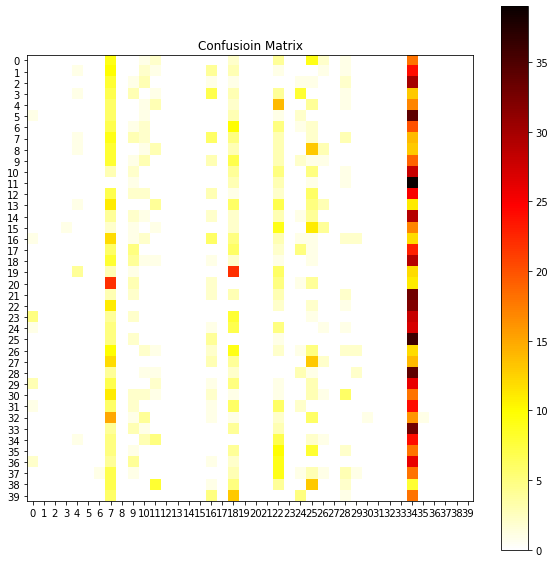

Accuracy of each class:
 tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.1875, 0.0000,
        0.0208, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.1250, 0.0000,
        0.0417, 0.0000, 0.0000, 0.0000, 0.0417, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.5000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000])
Recall of each class:
 tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0314, 0.0000,
        0.0196, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.1017, 0.0000,
        0.0118, 0.0000, 0.0000, 0.0000, 0.0134, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0272, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000])
Epoch 2/20: , lr = 0.0001
Step [10/240] Train Loss: 3.7327
Step [20/240] Train Loss: 3.6981
Step [30/240] Train Loss: 3.7082
Step [40/240] Train Loss: 3.7097
Step [50/240] Train Loss: 3.6833
Step [60/240] Train Loss: 3.6694
Step [

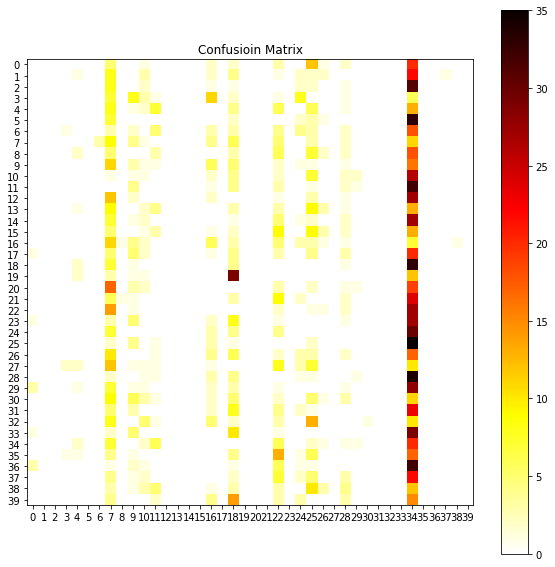

Accuracy of each class:
 tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.1875, 0.0000,
        0.0625, 0.0208, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.1250, 0.0000,
        0.0833, 0.0000, 0.0000, 0.0000, 0.0417, 0.0000, 0.0000, 0.0417, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.4167, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000])
Recall of each class:
 tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0349, 0.0000,
        0.0417, 0.0222, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0811, 0.0000,
        0.0244, 0.0000, 0.0000, 0.0000, 0.0146, 0.0000, 0.0000, 0.0147, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0238, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000])
Epoch 3/20: , lr = 5e-05
Step [10/240] Train Loss: 3.7281
Step [20/240] Train Loss: 3.6975
Step [30/240] Train Loss: 3.6878
Step [40/240] Train Loss: 3.6898
Step [50/240] Train Loss: 3.6710
Step [60/240] Train Loss: 3.6901
Step [7

In [ ]:
fit(net, num_epochs, optimizer, schedulr,device, nclasses)  #

In [52]:
training_dataset[0]

(tensor([[[-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          ...,
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.]],
 
         [[-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          ...,
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.]],
 
         [[-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          ...,
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.]]]),
 0)